# Access Sentinel-2 data from the CDSE STAC catalog
**A DeepESDL example notebook** 

This notebook demonstrates how to access Sentinel-2 data from CDSE via xcube-stac store. The data is fetched via the [CDSE STAC API](https://browser.stac.dataspace.copernicus.eu/?.language=en).

**The data can be accessed via S3, where key and secret can be obtained following the [CDSE access documentation to EO data via S3](https://documentation.dataspace.copernicus.eu/APIs/S3.html#generate-secrets). The store object will receive the key and secret upon initialization, as demonstrated below.**

Please, also refer to the [DeepESDL documentation](https://earthsystemdatalab.net/guide/jupyterlab) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

Brockmann Consult, 2025

-----------------

**This notebook runs with the python environment `users-deepesdl-xcube-1.11.1`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**

In [1]:
%%time

import matplotlib.pyplot as plt
import xarray as xr
from xcube.core.store import new_data_store, get_data_store_params_schema

from xcube_stac.utils import reproject_bbox

CPU times: user 2.23 s, sys: 493 ms, total: 2.72 s
Wall time: 4.07 s


In [2]:
xr.set_options(display_expand_attrs=False)

Next store the credentials in a dictionary. 

In [3]:
credentials = dict(
    key="xxx",
    secret="xxx",
)

There are two [data stores](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework) available for the [CDSE STAC API](https://browser.stac.dataspace.copernicus.eu/?language=en):

- **`stac-cdse-ardc`**: Allows you to open multiple STAC items and assemble them into a 3D spatiotemporal data cube.
- **`stac-cdse`**: Enables you to open individual STAC items.

---
## Data store to access spatiotemporal analysis-ready data cubes 
In the following, we will first demonstrate how to use the `stac-cdse-ardc` store. To view the parameters to initialize the data store instance, execute the following cell. 

> **Note:**  
> Access requires your S3 `key` and `secret`.

In [5]:
%%time
store_params = get_data_store_params_schema("stac-cdse-ardc")
store_params

CPU times: user 98.7 ms, sys: 56 ms, total: 155 ms
Wall time: 353 ms


In [6]:
%%time
store = new_data_store("stac-cdse-ardc", **credentials)

CPU times: user 14.7 ms, sys: 1.8 ms, total: 16.5 ms
Wall time: 115 ms


The following cell shows the available data IDs for the analysis-ready datacube mode. The data IDs point to a STAC collections.

In [7]:
%%time
data_ids = store.list_data_ids()
data_ids

CPU times: user 21 μs, sys: 6 μs, total: 27 μs
Wall time: 29.6 μs


['sentinel-2-l2a', 'sentinel-2-l1c', 'sentinel-3-syn-2-syn-ntc']

Below, the parameters for the `open_data` method can be viewed for a specific data ID.

In [8]:
%%time
open_params = store.get_open_data_params_schema("sentinel-2-l1c")
open_params

CPU times: user 120 ms, sys: 85.4 ms, total: 206 ms
Wall time: 680 ms


The store supports the collection `sentinel-2-l1c` and `sentinel-2-l2a`. We first get Sentinel-2 Level-1C data by assigning the `data_id` to `"sentinel-2-l1c"`. We set the bounding box to cover the greater Hamburg area and the time range to second half of July 2020.

In [9]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l1c",
    bbox=[9.7, 53.3, 10.3, 53.8],
    time_range=["2020-07-15", "2020-08-01"],
    spatial_res=10 / 111320,  # meter in degree
    crs="EPSG:4326",
    asset_names=["B02", "B03", "B04"],
    add_angles=True,
)
ds

CPU times: user 45.1 s, sys: 56 ms, total: 45.2 s
Wall time: 50.6 s


<xarray.Dataset> Size: 3GB
Dimensions:        (time: 7, lon: 6681, lat: 5567, angle_lon: 15,
                    angle_lat: 13, angle: 2, band: 3)
Coordinates:
  * time           (time) datetime64[ns] 56B 2020-07-16T10:40:31.024000 ... 2...
    spatial_ref    int64 8B 0
  * lon            (lon) float64 53kB 9.7 9.7 9.7 9.7 ... 10.3 10.3 10.3 10.3
  * lat            (lat) float64 45kB 53.8 53.8 53.8 53.8 ... 53.3 53.3 53.3
  * angle_lon      (angle_lon) float64 120B 9.723 9.768 9.814 ... 10.32 10.36
  * angle_lat      (angle_lat) float64 104B 53.86 53.82 53.77 ... 53.37 53.32
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B02            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    solar_angle    (angle, time, angle_lat, angle_lon) float32 11kB dask.array<chunksize=(2, 1, 13, 15), meta=np.ndarray>
    viewing_angle  (angle, band, time, angle_lat, angle_lon) float32 33kB dask.array<chunksize=(2, 3, 1, 13, 15), meta=np.ndarray>
Attributes: (3)

We can plot the B04 (red) band for a given timestamp as an example. Hereby a mosaicking of multiple tiles have been applied. Additionally, we plot the solar and viewing angle.

CPU times: user 12.7 s, sys: 260 ms, total: 13 s
Wall time: 15.7 s


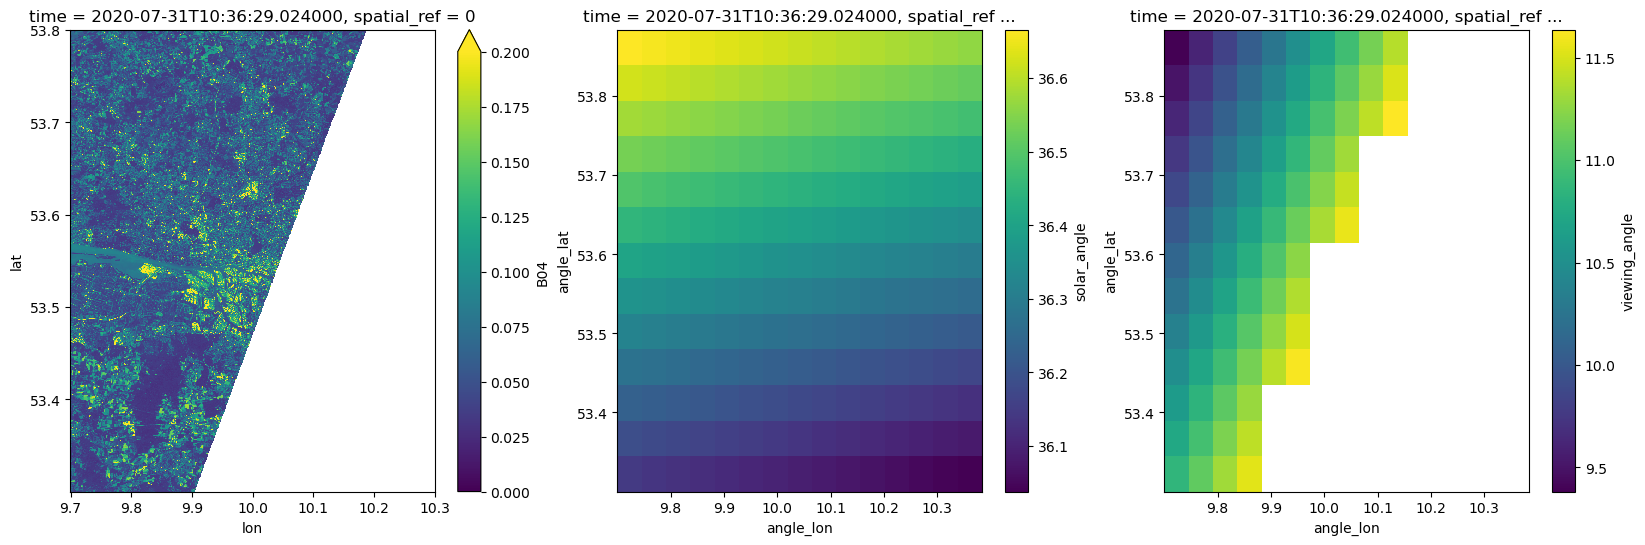

In [10]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ds.B04.isel(time=-1)[::10, ::10].plot(ax=ax[0], vmin=0, vmax=0.2)
ds.solar_angle.isel(angle=0, time=-1).plot(ax=ax[1])
ds.viewing_angle.isel(band=2, angle=0, time=-1).plot(ax=ax[2])

Next we retrieve the same data cube, but for Level-2a by assigning the `data_id` to `sentinel-2-l2a`.

In [11]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=[9.7, 53.3, 10.3, 53.8],
    time_range=["2020-07-15", "2020-08-01"],
    spatial_res=10 / 111320,  # meter in degree
    crs="EPSG:4326",
    asset_names=["B02", "B03", "B04", "SCL"],
    add_angles=True,
)
ds

CPU times: user 56.6 s, sys: 167 ms, total: 56.7 s
Wall time: 1min 2s


<xarray.Dataset> Size: 4GB
Dimensions:        (time: 7, lon: 6681, lat: 5567, angle_lon: 15,
                    angle_lat: 13, angle: 2, band: 3)
Coordinates:
  * time           (time) datetime64[ns] 56B 2020-07-16T10:40:31.024000 ... 2...
    spatial_ref    int64 8B 0
  * lon            (lon) float64 53kB 9.7 9.7 9.7 9.7 ... 10.3 10.3 10.3 10.3
  * lat            (lat) float64 45kB 53.8 53.8 53.8 53.8 ... 53.3 53.3 53.3
  * angle_lon      (angle_lon) float64 120B 9.723 9.768 9.814 ... 10.32 10.36
  * angle_lat      (angle_lat) float64 104B 53.86 53.82 53.77 ... 53.37 53.32
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B02            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SCL            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    solar_angle    (angle, time, angle_lat, angle_lon) float32 11kB dask.array<chunksize=(2, 1, 13, 15), meta=np.ndarray>
    viewing_angle  (angle, band, time, angle_lat, angle_lon) float32 33kB dask.array<chunksize=(2, 3, 1, 13, 15), meta=np.ndarray>
Attributes: (3)

We can plot the B04 (red) band for a given timestamp as an example. Hereby a mosaicking of multiple tiles have been applied. Additionally, we plot the solar and viewing angle.


CPU times: user 12.4 s, sys: 212 ms, total: 12.6 s
Wall time: 14.7 s


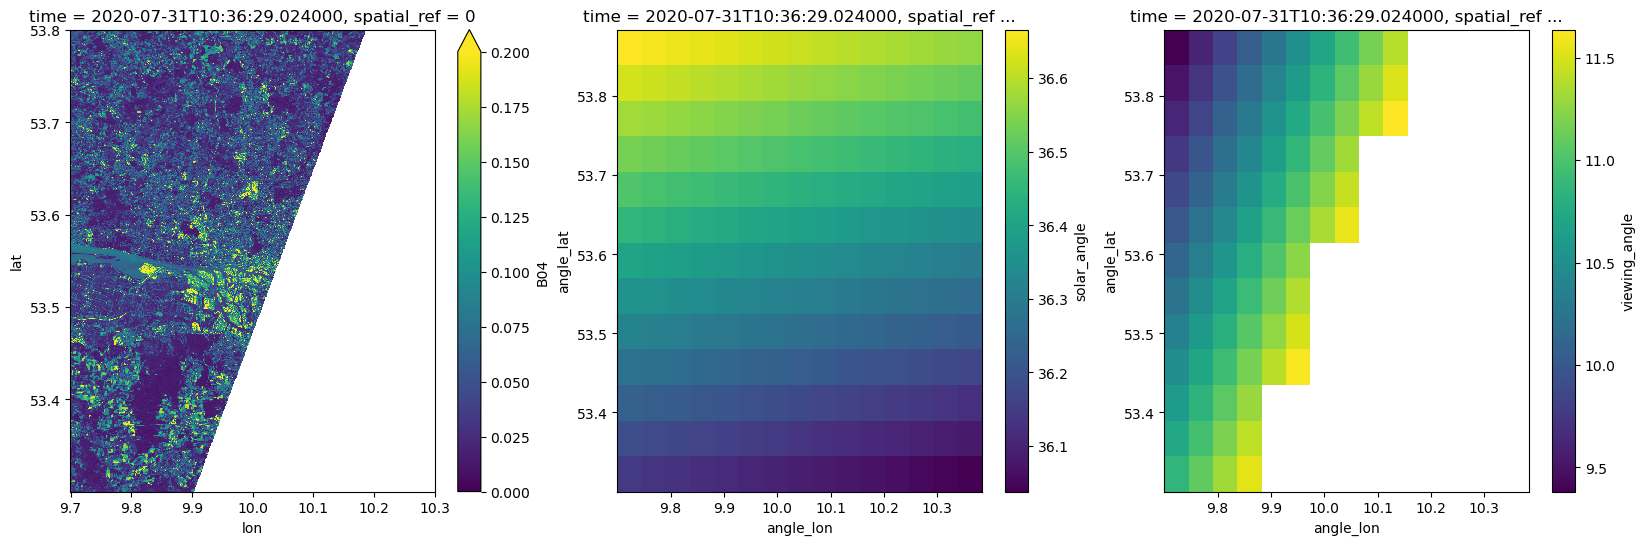

In [12]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ds.B04.isel(time=-1)[::10, ::10].plot(ax=ax[0], vmin=0, vmax=0.2)
ds.solar_angle.isel(angle=0, time=-1).plot(ax=ax[1])
ds.viewing_angle.isel(band=2, angle=0, time=-1).plot(ax=ax[2])

The data access can be sped up when requesting the data in the UTM CRS which is the native UTM of the Sentinel-2 products. 

In [13]:
%%time
bbox = [9.7, 53.3, 10.3, 53.8]
crs_target = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_target)

CPU times: user 1.42 ms, sys: 0 ns, total: 1.42 ms
Wall time: 771 μs


In [14]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2020-07-15", "2020-08-01"],
    spatial_res=10,
    crs=crs_target,
    asset_names=["B02", "B03", "B04", "SCL"],
    add_angles=True,
)
ds

CPU times: user 6.07 s, sys: 64 ms, total: 6.14 s
Wall time: 14.8 s


<xarray.Dataset> Size: 4GB
Dimensions:        (time: 11, y: 5619, x: 4054, angle_x: 10, angle_y: 13,
                    angle: 2, band: 3)
Coordinates:
  * time           (time) datetime64[ns] 88B 2020-07-15T10:15:59.024000 ... 2...
    spatial_ref    int64 8B 0
  * x              (x) float64 32kB 5.461e+05 5.461e+05 ... 5.866e+05 5.866e+05
  * y              (y) float64 45kB 5.962e+06 5.962e+06 ... 5.906e+06 5.906e+06
  * angle_x        (angle_x) float64 80B 5.486e+05 5.536e+05 ... 5.936e+05
  * angle_y        (angle_y) float64 104B 5.968e+06 5.963e+06 ... 5.908e+06
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B02            (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03            (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04            (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SCL            (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    solar_angle    (angle, time, angle_y, angle_x) float32 11kB dask.array<chunksize=(2, 1, 13, 10), meta=np.ndarray>
    viewing_angle  (angle, band, time, angle_y, angle_x) float32 34kB dask.array<chunksize=(2, 3, 1, 13, 10), meta=np.ndarray>
Attributes: (3)

We can plot the B04 (red) band for a given timestamp as an example. Hereby a mosaicking of multiple tiles have been applied. Additionally, we plot the solar and viewing angle.

CPU times: user 5.99 s, sys: 76.3 ms, total: 6.07 s
Wall time: 6.05 s


/home/conda/users/60ba36d6-1759325445-137-deepesdl-xcube-1.11.1/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


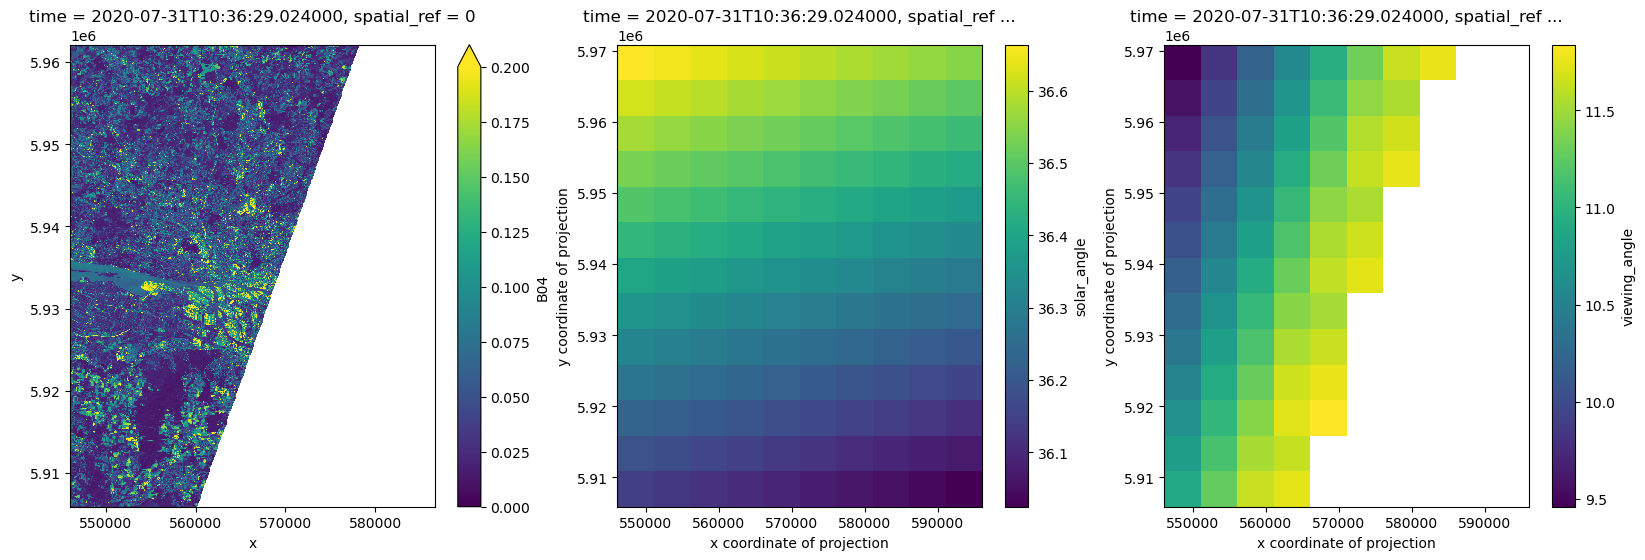

In [15]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ds.B04.isel(time=-1)[::10, ::10].plot(ax=ax[0], vmin=0, vmax=0.2)
ds.solar_angle.isel(angle=0, time=-1).plot(ax=ax[1])
ds.viewing_angle.isel(band=2, angle=0, time=-1).plot(ax=ax[2])

### Fast timeseries cube generation (single-tile mode)

There is also a timeseries mode available that generates a time series cube from a single Sentinel-2 tile. Instead of providing `bbox` and `crs`, you now supply a `point` (lon, lat) together with a `bbox_width` in meters (must be < 10,000). The system will cut out a region around the given point, restricted to a single tile and native crs, and stack it along the time dimension. This improves cube generation performance. 

Below we again view the `open_params`, where the second group shows the parameters needed to trigger the single-tile mode. 

In [16]:
%%time
store.get_open_data_params_schema(data_id="sentinel-2-l2a")

CPU times: user 13.1 ms, sys: 13 μs, total: 13.1 ms
Wall time: 12.4 ms


In [17]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    point=(10.3, 53.3),
    bbox_width=1000,
    time_range=["2020-07-15", "2020-08-01"],
    spatial_res=10,
    asset_names=["B02", "B03", "B04", "SCL"],
)
ds

CPU times: user 1.41 s, sys: 48 ms, total: 1.45 s
Wall time: 5.11 s


<xarray.Dataset> Size: 482kB
Dimensions:      (time: 3, y: 100, x: 100)
Coordinates:
  * x            (x) float64 800B 5.861e+05 5.862e+05 ... 5.871e+05 5.871e+05
  * y            (y) float64 800B 5.907e+06 5.907e+06 ... 5.906e+06 5.906e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 24B 2020-07-18T10:25:59.024000 ... 202...
Data variables:
    B02          (time, y, x) float32 120kB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    B03          (time, y, x) float32 120kB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    B04          (time, y, x) float32 120kB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    SCL          (time, y, x) float32 120kB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes: (4)

CPU times: user 1.11 s, sys: 36.3 ms, total: 1.15 s
Wall time: 7.03 s


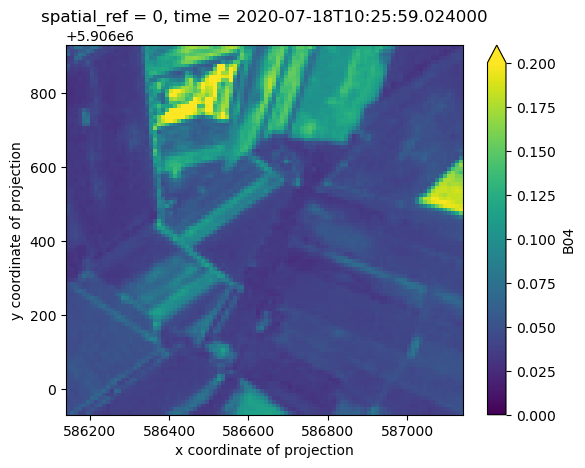

In [18]:
%%time
ds.B04.isel(time=0).plot(vmin=0, vmax=0.2)

----
## Data store to access single observations
Now, we initiate the data store to access each STAC item representing one observation tile. 

In [19]:
%%time
store = new_data_store("stac-cdse", **credentials)

CPU times: user 13.1 ms, sys: 0 ns, total: 13.1 ms
Wall time: 89.2 ms


In the next step, we can search for items using search parameters. The following code shows which search parameters are available.

In [20]:
%%time
search_params = store.get_search_params_schema()
search_params

CPU times: user 27 μs, sys: 1e+03 ns, total: 28 μs
Wall time: 28.6 μs


 Next, we will search for tiles of Sentinel-2 data. The data IDs point to a [STAC item's JSON](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) and are specified by the segment of the URL that follows the catalog's URL.

In [21]:
%%time
descriptors = list(
    store.search_data(
        collections=["sentinel-2-l2a"],
        bbox=[9, 47, 10, 48],
        time_range=["2020-07-01", "2020-07-05"],
    )
)
[d.to_dict() for d in descriptors]

CPU times: user 262 ms, sys: 36.1 ms, total: 298 ms
Wall time: 3.42 s


[{'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32UNU_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.999728, 47.755819, 10.493269, 48.753013],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32UMU_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.087776, 47.759622, 9.132783, 48.752937],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32TNT_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.999733, 46.85664, 10.467277, 47.853702],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32TMT_20230530T175912',
  'data_type': 'dataset',
  'bbox': [7.760786, 46.858555, 9.13047, 47.853628],
  'time_range':

In the next step, we can open the data for each data ID. The following code shows which parameters are available for opening the data.

In [22]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 32 μs, sys: 1e+03 ns, total: 33 μs
Wall time: 35.3 μs


We select the band B04 (red), B03 (green), B02 (blue), and the science classification layer (SLC), and lazily load the corresponding data.

In [23]:
%%time
ds = store.open_data(
    "collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32TMT_20230530T175912",
    asset_names=["B04", "B03", "B02", "SCL"],
    add_angles=True,
)
ds

CPU times: user 291 ms, sys: 4.03 ms, total: 295 ms
Wall time: 1.54 s


<xarray.Dataset> Size: 2GB
Dimensions:        (y: 10980, x: 10980, angle_x: 23, angle_y: 23, angle: 2,
                    band: 3)
Coordinates:
  * x              (x) float64 88kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y              (y) float64 88kB 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
    spatial_ref    int64 8B 0
  * angle_x        (angle_x) float64 184B 4.025e+05 4.075e+05 ... 5.125e+05
  * angle_y        (angle_y) float64 184B 5.303e+06 5.298e+06 ... 5.193e+06
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B04            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B03            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B02            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    SCL            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    solar_angle    (angle, angle_y, angle_x) float32 4kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
    viewing_angle  (angle, band, angle_y, angle_x) float32 13kB dask.array<chunksize=(2, 3, 23, 23), meta=np.ndarray>
Attributes: (3)

We plot the loaded data as an example below.

CPU times: user 17.2 s, sys: 441 ms, total: 17.7 s
Wall time: 18.4 s


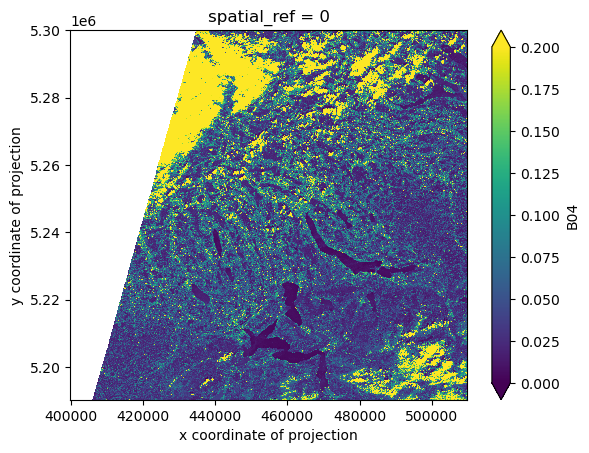

In [24]:
%%time
ds.B04[::10, ::10].plot(vmin=0.0, vmax=0.2)

Next, we do the same for Sentine-2 Level-1C. We first search in the collection `sentinel-2-l1c` and open one tile. 

In [25]:
%%time
descriptors = list(
    store.search_data(
        collections=["sentinel-2-l1c"],
        bbox=[9, 47, 10, 48],
        time_range=["2020-07-01", "2020-07-05"],
    )
)
[d.to_dict() for d in descriptors]

CPU times: user 200 ms, sys: 7.96 ms, total: 208 ms
Wall time: 3.14 s


[{'data_id': 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20200705T101559_N0500_R065_T32UNU_20230530T084300',
  'data_type': 'dataset',
  'bbox': [8.999728, 47.755819, 10.493269, 48.753013],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20200705T101559_N0500_R065_T32UMU_20230530T084300',
  'data_type': 'dataset',
  'bbox': [8.087776, 47.759622, 9.132783, 48.752937],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20200705T101559_N0500_R065_T32TNT_20230530T084300',
  'data_type': 'dataset',
  'bbox': [8.999733, 46.85664, 10.467277, 47.853702],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20200705T101559_N0500_R065_T32TMT_20230530T084300',
  'data_type': 'dataset',
  'bbox': [7.760786, 46.858555, 9.13047, 47.853628],
  'time_range':

In [26]:
%%time
ds = store.open_data(
    "collections/sentinel-2-l1c/items/S2B_MSIL1C_20200705T101559_N0500_R065_T32TMT_20230530T084300",
    asset_names=["B04", "B03", "B02"],
    add_angles=True,
)
ds

CPU times: user 200 ms, sys: 4.01 ms, total: 204 ms
Wall time: 1.05 s


<xarray.Dataset> Size: 1GB
Dimensions:        (x: 10980, y: 10980, angle_x: 23, angle_y: 23, angle: 2,
                    band: 3)
Coordinates:
  * x              (x) float64 88kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y              (y) float64 88kB 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
    spatial_ref    int64 8B 0
  * angle_x        (angle_x) float64 184B 4.025e+05 4.075e+05 ... 5.125e+05
  * angle_y        (angle_y) float64 184B 5.303e+06 5.298e+06 ... 5.193e+06
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B04            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B03            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B02            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    solar_angle    (angle, angle_y, angle_x) float32 4kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
    viewing_angle  (angle, band, angle_y, angle_x) float32 13kB dask.array<chunksize=(2, 3, 23, 23), meta=np.ndarray>
Attributes: (3)

CPU times: user 16.6 s, sys: 266 ms, total: 16.9 s
Wall time: 19.3 s


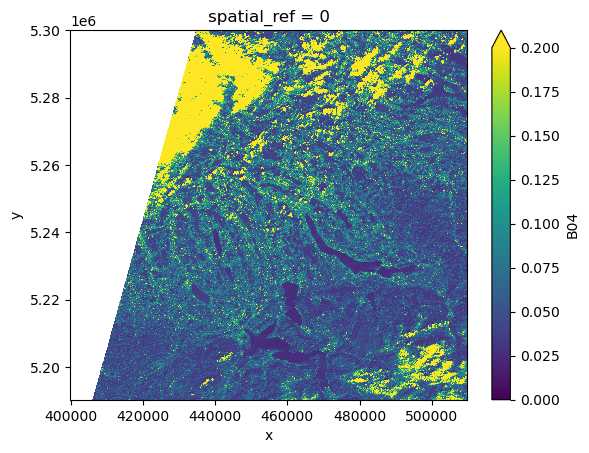

In [27]:
%%time
ds.B04[::10, ::10].plot(vmin=0.0, vmax=0.2)